In [1]:
import dlib, cv2
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import ImageFont, ImageDraw, Image
import tensorflow.keras 
from tensorflow.keras import backend as K 


In [2]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
facerec = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')

In [15]:
####Face Detector
def find_faces(img):
    dets = detector(img, 5)

    if len(dets)==0:
        return np.empty(0), np.empty(0), np.empty(0)
    rects, shapes = [], []
    shapes_np = np.zeros((len(dets), 68, 2), dtype=np.int)
    for k, d in enumerate(dets):
        rect = ((d.left(), d.top()), (d.right(), d.bottom()))
        rects.append(rect)

        shape = sp(img, d)

        #Convert dlib shape to numpy array
        for i in range(0, 68):
            shapes_np[k][i] = (shape.part(i).x, shape.part(i).y)

        shapes.append(shape)
    return rects, shapes, shapes_np

####Extract langmark
def encode_faces(img, shapes):
    face_descriptors = []
    for shape in shapes:
        face_descriptor = facerec.compute_face_descriptor(img, shape)
        face_descriptors.append(np.array(face_descriptor))

    return np.array(face_descriptors)

In [16]:
####Make DataBase

#Pick image files
img_paths = {
            'jingoo':'yjg.jpg',
            'yeonhee':'lyh.jpg',
            'saeyoon':'msy.jpg'}

#extract special persons' image ->save
descs = []

for name, img_path in img_paths.items():
    img = cv2.imread(img_path)
    _, img_shapes, M= find_faces(img)
    descs.append([name, encode_faces(img, img_shapes)[0]])

np.save('results/descs.npy', descs)
print(descs)

[['jingoo', array([-0.14223649,  0.00570615,  0.00827103, -0.09453086, -0.14687625,
       -0.06745842, -0.08877908, -0.12272538,  0.10983381, -0.09839856,
        0.16798484,  0.0131189 , -0.13367823, -0.08305821, -0.08293343,
        0.10932334, -0.15254883, -0.15404725,  0.0279912 , -0.01688141,
        0.13077815,  0.03375506, -0.02695514,  0.05914477, -0.17145288,
       -0.26889971, -0.15687591, -0.07125054, -0.10506655, -0.01778533,
        0.01689689,  0.07920699, -0.17092098,  0.00634482,  0.03557274,
        0.11305513,  0.02344528,  0.0092537 ,  0.07814   ,  0.06260098,
       -0.2596904 ,  0.08852463,  0.08205596,  0.26926279,  0.25252008,
        0.02444722, -0.00312309, -0.09256663,  0.09187631, -0.15683199,
        0.02364006,  0.19584508,  0.05855822,  0.01890434,  0.02157919,
       -0.07263033,  0.05369166,  0.18170156, -0.14787576,  0.02916226,
        0.10598724, -0.1250501 , -0.0067939 , -0.06623841,  0.16637295,
        0.0941869 , -0.12750421, -0.21191351,  0.101

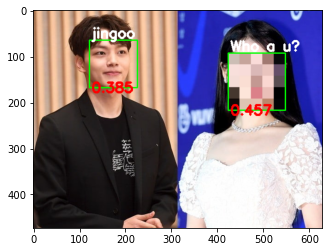

In [17]:
####Detecting faces & Mosaic
img = cv2.imread('testset/jingoo_iu.jpg')
rects, shapes, _=find_faces(img) # detect faces
descriptors = encode_faces(img, shapes) # encoding
font = cv2.FONT_HERSHEY_SIMPLEX # 폰트

for i, desc in enumerate(descriptors):
    x = rects[i][0][0] # x
    y = rects[i][0][1] #y
    w = rects[i][1][1]-rects[i][0][1] # width
    h = rects[i][1][0]-rects[i][0][0] # height

    #Find the shortest distance between landmark and database
    descs1 = sorted(descs, key=lambda x: np.linalg.norm([desc]-x[1]))
    dist = np.linalg.norm([desc]-descs1[0][1], axis=1)

    if dist <0.45: #if the distance is shorter than 0.45, it matched!
        name = descs1[0][0]
    else:
        name="Who a u?"
        mosaic_img = cv2.resize(img[y:y+h, x:x+w], dsize = (0,0), fx=0.04, fy=0.04) #reduced size
        mosaic_img = cv2.resize(mosaic_img, (w,h), interpolation=cv2.INTER_AREA) #expanded size
        img[y:y+h, x:x+w] = mosaic_img #Mosaic the recognized faces

    cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0),2) # box of face part
    cv2.putText(img, str(dist)[1:6], (x+5,y+h+10), font, 1, (0,0,255), 4) # distance 
    cv2.putText(img, name, (x+5,y-5), font, 1, (255,255,255), 4)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)






